In [1]:
# !pip install odfpy
# !pip install seaborn
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yaml
from yaml import Loader
import numpy as np
import analyze_cells_energy as ace
import utils
from scipy.stats import ttest_ind, mannwhitneyu
import networkx as nx
import matplotlib.pyplot as plt
from scipy.stats import f_oneway, kruskal
import utils_PLS as upls
import scikit_posthocs as sp

In [2]:
root_directory = '/home/stella/Documents/Torino/projects/'
experiment = 'SexualImprinting'
experimental_group = 'BL_wf_USV_Bedding_wb'
data_directory = root_directory + experiment + '/' \
                + experimental_group + '/'
subjects = [name for name in os.listdir(data_directory) \
            if os.path.isdir(os.path.join(data_directory, name))]

In [3]:
# load query file where we added volumes for each area
volumes = ace.clean_volumes_database()

In [4]:
def load_subject(subject, data_directory, threshold):
    file_suffix = 'cells_' + str(threshold)
    df_mouse = pd.read_csv(data_directory + subject + '/' + file_suffix + '.csv')
    df_mouse = ace.reformat_df_mouse(df=df_mouse)
    
    return df_mouse

In [5]:
def print_results(experimental_groups, groups_df, area=None):
    for i, df in zip(experimental_groups.keys(), groups_df):
        print(i)
        if area==None:
            print(df.set_index('area').sum().to_string())
        else:
            print(df.set_index('area').loc[area].to_string())
        print(' ')

# Analysis on Black with father Whole Brain USVs and Bedding

In [6]:
# dict_results_across_mice = {subject: ace.calculate_cells_energy_per_level(
#     df_mouse=load_subject(subject=subject, 
#                           data_directory=data_directory,
#                           threshold=2500),
#     vol=volumes,
#     level=8) for subject in subjects}
# np.save('dict_results/dict_results_across_mice_BL_wf_USV_Bedding_wb.npy', dict_results_across_mice)

In [7]:
dict_results_across_mice = np.load('dict_results/dict_results_across_mice_BL_wf_USV_Bedding_wb.npy', 
                                   allow_pickle=True).item()

In [8]:
subjects = list(dict_results_across_mice.keys())

# List areas with null cell count

In [9]:
db_null_count = {subject: dict_results_across_mice[subject][
    dict_results_across_mice[subject].n_cells == 0] for subject in subjects}

# List areas with no volume

In [10]:
db_null_volume = {subject: dict_results_across_mice[subject][
    dict_results_across_mice[subject]['energy'].isnull()] for subject in subjects}

# Divide mice into experimental groups: FAM/UNFAM/CONTROL

In [11]:
experimental_groups = utils.divide_in_exp_groups(list_subjects=subjects,
                                                group_labels=['Control',
                                                       'USVC57',
                                                       'USVBALB',
                                                       'USVBALB_Bedding',
                                                       'USVC57_Bedding',
                                                       'Bedding'])

# Calculate cell count across experimental groups

In [12]:
df_Control_cell_count, df_USVC57_cell_count, df_USVBALB_cell_count,\
df_USVBALB_Bedding_cell_count, df_USVC57_Bedding_cell_count, df_Bedding_cell_count = \
ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                              dict_results_across_mice=dict_results_across_mice, 
                              value='n_cells')
groups_df = [df_Control_cell_count, df_USVC57_cell_count, df_USVBALB_cell_count,\
df_USVBALB_Bedding_cell_count, df_USVC57_Bedding_cell_count, df_Bedding_cell_count]

# Look at cell count per area

In [13]:
print_results(experimental_groups=experimental_groups,
              groups_df=groups_df,
             area='Inferior colliculus')

Control
BL55Control    1799
BL79Control     701
BL69Control     515
BL62Control     626
BL74Control     418
BL92Control     418
BL85Control     334
 
USVC57
BL81USVC57     542
BL73USVC57     985
BL86USVC57     263
BL67USVC57    1070
BL56USVC57    1013
BL93USVC57     479
BL63USVC57     979
 
USVBALB
BL87USVBALB    1025
BL61USVBALB     525
BL80USVBALB     650
BL68USVBALB    1336
BL91USVBALB     327
BL57USVBALB     553
BL75USVBALB     640
 
USVBALB_Bedding
BL78USVBALB_Bedding     699
BL58USVBALB_Bedding     479
BL71USVBALB_Bedding     687
BL88USVBALB_Bedding     539
BL94USVBALB_Bedding     363
BL64USVBALB_Bedding    1193
BL84USVBALB_Bedding     805
 
USVC57_Bedding
BL77USVC57_Bedding     869
BL59USVC57_Bedding    2096
BL89USVC57_Bedding     502
BL70USVC57_Bedding     927
BL82USVC57_Bedding     544
BL96USVC57_Bedding     469
BL66USVC57_Bedding    1040
 
Bedding
BL95Bedding     293
BL60Bedding    1172
BL72Bedding     924
BL83Bedding     439
BL65Bedding     896
BL76Bedding     212
BL90Beddin

# Calculate anova across groups

In [14]:
def boxplot(dfs, value):
    df = pd.concat(dfs, ignore_index=True)

    f, ax = plt.subplots(ncols=1, nrows=1, figsize=(5,5), sharey=True)
    sns.boxplot(
        data=df,
        x="group", y=value, palette="Accent", ax=ax)
    ax.set_xlabel('')
    ax.tick_params(axis='x', labelrotation=90)


n_cells
KruskalResult(statistic=3.767916468913171, pvalue=0.5832902112739948)
energy
KruskalResult(statistic=12.354532510678695, pvalue=0.030239893209611072)
density
KruskalResult(statistic=11.333175130517304, pvalue=0.04515994893109083)
relative_density
KruskalResult(statistic=17.72899857617466, pvalue=0.003305941658094609)


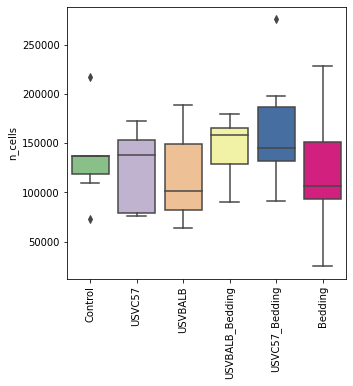

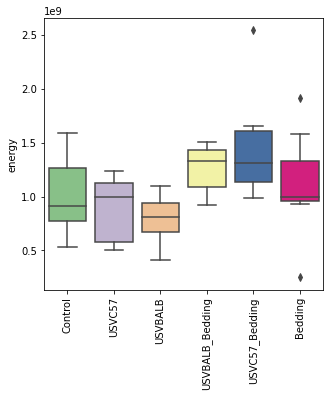

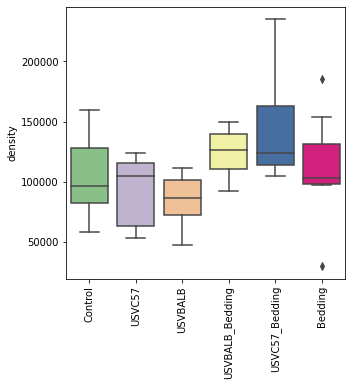

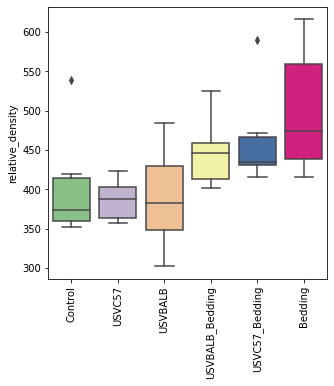

In [17]:
for value in ['n_cells', 'energy', 'density', 'relative_density']:
    boxplot(ace.create_dfs_across_groups(dictionary_results=dict_results_across_mice, 
        experimental_groups=experimental_groups, 
        value=value), value=value)
    print(value)
    dfs = ace.create_dfs_across_groups(dictionary_results=dict_results_across_mice, 
            experimental_groups=experimental_groups, 
            value=value)
    
    print(kruskal(*[dfs[key][value].to_numpy() for key in dfs.keys()]))

In [18]:
sig_ncells = ace.kruskal_per_area(dictionary=dict_results_across_mice,
                 value='n_cells', experimental_groups=experimental_groups)

In [92]:
df = sig_ncells['Central linear nucleus raphe'][1]< 0.05
lst = df.where(df).stack().index.to_list()
b = [tuple(sorted(s)) for s in set(frozenset(i) for i in lst)]
b

[('Control', 'USVC57_Bedding'),
 ('Bedding', 'USVBALB'),
 ('USVBALB', 'USVBALB_Bedding'),
 ('USVBALB', 'USVC57_Bedding')]

In [82]:
b

[('Control', 'USVBALB_Bedding'),
 ('USVBALB_Bedding', 'USVC57'),
 ('USVC57', 'USVC57_Bedding'),
 ('Bedding', 'USVC57'),
 ('USVBALB', 'USVBALB_Bedding'),
 ('Bedding', 'USVBALB'),
 ('USVBALB', 'USVC57_Bedding')]

In [41]:
for key in sig_ncells.keys():
    print(key)

Infralimbic area
Accessory olfactory bulb
Cortical amygdalar area
Piriform-amygdalar area
Postpiriform transition area
Basomedial amygdalar nucleus
Posterior amygdalar nucleus
Bed nucleus of the accessory olfactory tract
Intercalated amygdalar nucleus
Medial amygdalar nucleus
Magnocellular nucleus
Bed nuclei of the stria terminalis
Suprageniculate nucleus
Submedial nucleus of the thalamus
Paraventricular hypothalamic nucleus
Arcuate hypothalamic nucleus
Anterodorsal preoptic nucleus
Anteroventral preoptic nucleus
Anteroventral periventricular nucleus
Medial preoptic area
Posterodorsal preoptic nucleus
Parastrial nucleus
Periventricular hypothalamic nucleus posterior part
Periventricular hypothalamic nucleus preoptic part
Supramammillary nucleus
Tuberomammillary nucleus
Medial preoptic nucleus
Dorsal premammillary nucleus
Ventral premammillary nucleus
Ventromedial hypothalamic nucleus
Lateral preoptic area
Tuberal nucleus
Lateral terminal nucleus of the accessory optic tract
Interfascic

In [19]:
sig_energy = ace.kruskal_per_area(dictionary=dict_results_across_mice,
                 value='energy', experimental_groups=experimental_groups)

In [20]:
sig_density = ace.kruskal_per_area(dictionary=dict_results_across_mice,
                 value='density', experimental_groups=experimental_groups)

In [21]:
sig_rel_density = ace.kruskal_per_area(dictionary=dict_results_across_mice,
                 value='relative_density', experimental_groups=experimental_groups)

In [22]:
len(sig_ncells), len(sig_energy), len(sig_density), len(sig_rel_density)

(35, 30, 35, 37)

In [23]:
set(sig_ncells).difference(set(sig_energy))

{'Bed nucleus of the accessory olfactory tract',
 'Lateral terminal nucleus of the accessory optic tract',
 'Paraventricular hypothalamic nucleus',
 'Suprageniculate nucleus',
 'Supramammillary nucleus'}